# Assignment 2

# Karunanayaka Y.S (190301H)

Github Repository: https://github.com/YSK-Machine-Vision-EN2550/Assignment_2.git

In [1]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import cv2 as cv

In [2]:
N = 100
half_n = N // 2
r = 10
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )

In [3]:
# calculate the best fit circle
probability = 0.99
outlier_ratio = 0.40
trsh_dist = 0.9
s = 3
Itterations = int(np.log(1-probability)/np.log(1-(1-outlier_ratio)**s))

In [16]:
def RANSAC(X_circ, Itterations, trsh_dist):
    
    random_indexes = np.random.choice(range(X_circ.shape[0]), Itterations, replace=False)
    random_circles = []
    
    for i, _ in range(Itterations):
        # get three random points from the random samples
        r_points = [X_circ[j] for j in random_indexes]
        
        x, y = np.hsplit(np.array(r_points), 2)
        x, y = x.T[0], y.T[0]

        f = ((x[0]**2-x[1]**2+y[0]**2-y[1]**2)*(x[0]-x[2])-(x[0]**2-x[2]**2+y[0]**2-y[2]**2)*(x[0]-x[1]))/(2*((y[0]-y[2])*(x[0]-x[1])-(y[0]-y[1])*(x[0]-x[2])))
        g = ((x[0]**2-x[1]**2+y[0]**2-y[1]**2)*(y[0]-y[2])-(x[0]**2-x[2]**2+y[0]**2-y[2]**2)*(y[0]-y[1]))/(2*((y[0]-y[1])*(x[0]-x[2])-(y[0]-y[2])*(x[0]-x[1])))
        a, b, r = -g, -f, np.sqrt((x[0] + g)**2 + (y[0] + f)**2)
        
        random_circles.append((a,b,r))
        
    max_inliers = 0
    inliers = []
    circle = []
    
    for r_c in random_circles: # for each random circle
        counter = 0
        points = []
        for pt in r_points: # for each random point
            del_dist = abs(np.sqrt((pt[0] - r_c[0])**2 + (pt[1] - r_c[1])**2) - r)
            if del_dist < trsh_dist:
                counter += 1
                points.append(pt)
        if counter > max_inliers:
            max_inliers = counter
            inliers = points
            circle = r_c
            
    return circle, np.array(inliers)
                
        
while True:
    try:
        circle1, inliers1 = RANSAC(X_circ, Itterations, trsh_dist)
        circle2, inliers2 = RANSAC(inliers1, Itterations, trsh_dist)
        break
    except ValueError:
        pass

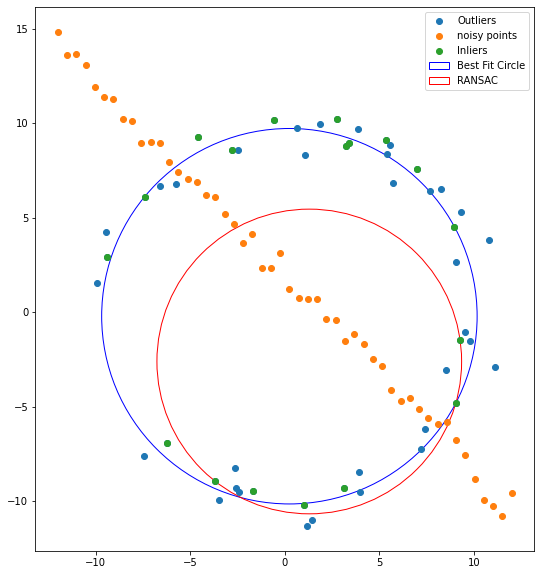

In [17]:
figure, axes = plt.subplots(figsize = (10,10))
axes.plot(X_circ[:,0],X_circ[:,1],'o',label = 'Outliers')
axes.plot(X_line[:,0],X_line[:,1],'o',label = 'noisy points')
axes.plot(inliers1[:,0], inliers1[:, 1], 'o',label = 'Inliers')

circle_1 = plt.Circle((circle1[0], circle1[1]),circle1[2],fill = False,color = 'blue',label = 'Best Fit Circle')
circle_2 = plt.Circle((circle2[0], circle2[1]),circle2[2],fill = False,color = 'red',label = 'RANSAC')

axes.set_aspect(1)
axes.add_artist(circle_1)
axes.set_aspect( 1 )
axes.add_artist(circle_2)

plt.legend()

plt.show()

## Question 2

In [87]:
def mousePoint(event, x,y,flags,params):
    if event == cv.EVENT_LBUTTONDOWN:
        imgPoints.append([x,y,1])
        
def findHomography(imgPoints, warpingImg):

    XT = np.array(
        [[0,0,1], [UK.shape[1] - 1, 0, 1], [UK.shape[1] - 1, UK.shape[0] - 1, 1], [0, UK.shape[0] - 1, 1]], dtype = np.float64
    )

    OT = np.array([0,0,0], dtype = np.float64)
    IP = np.array(imgPoints).astype(np.float64)
    A = np.zeros((1, 9), dtype = np.float64)

    for i in range(4):
        B = np.array(
            [
                np.concatenate((OT, XT[i], -IP[i][1] * XT[i]), axis = 0),
                np.concatenate((XT[i], OT, -IP[i][0] * XT[i]), axis = 0)
            ],
            dtype = np.float64
        )
        A = np.concatenate((A, B), axis = 0)

    A = A[1:]
    W, V = np.linalg.eig(A.T @ A)
    H = V[:, np.where(W == np.min(W))[0][0]].reshape(3,3)
    
    return H

Text(0.5, 1.0, 'Overlayed Image')

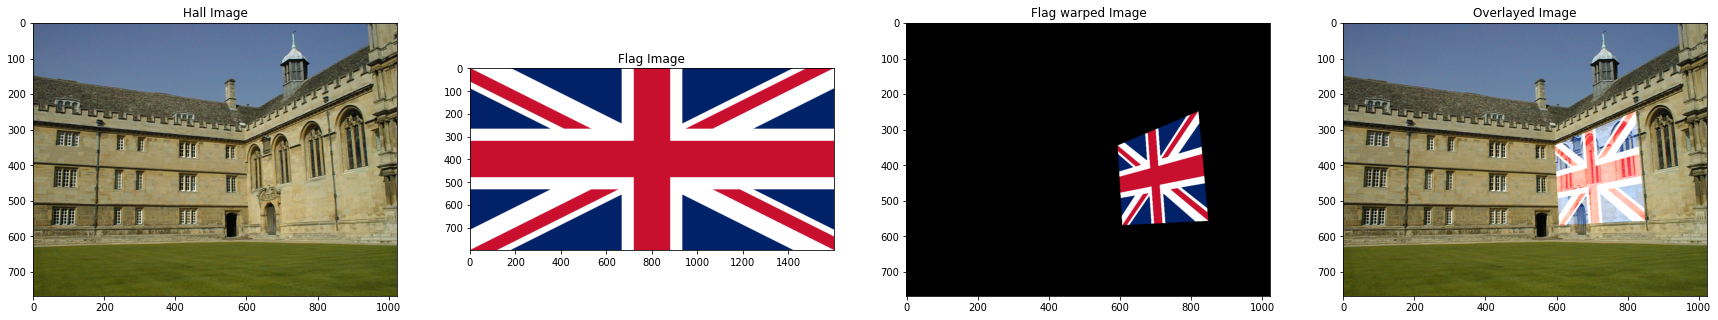

In [94]:
imgPoints = []
hall = cv.imread("003.jpg")
UK = cv.imread("UK.png")
cv.imshow('ImageWindow', hall)
cv.setMouseCallback('ImageWindow',mousePoint)
cv.waitKey(0)

H = findHomography(imgPoints, UK)

new_img = cv.warpPerspective(UK, H, hall.shape[1::-1])
overlayed_img = cv.add(hall, new_img)
cv.imshow("warped and overlayed", overlayed_img)
cv.waitKey(0)

fig, ax = plt.subplots(1, 4, figsize = (30, 15))

ax[0].imshow(cv.cvtColor(hall, cv.COLOR_BGR2RGB))
ax[0].set_title("Hall Image")
ax[1].imshow(cv.cvtColor(UK, cv.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv.cvtColor(new_img, cv.COLOR_BGR2RGB))
ax[2].set_title("Flag warped Image")
ax[3].imshow(cv.cvtColor(overlayed_img, cv.COLOR_BGR2RGB))
ax[3].set_title("Overlayed Image")

-1